# Plotting and correcting permeablity data

Here is the method to process the raw volumetic flow and pressure differential data to calculate permeability. This data is then corrected where needed for gas turbulence and gas slippage. See Appendix A5 for details of the different corrections applied to permeability data.

In [1]:
import pandas as pd
import numpy as np
from pandas import Series
from pandas import DataFrame
import matplotlib.pyplot as plt
import math

Three samples have been chosen to demonstrate the changes that corrections make to the permeability measurement calculated from the raw data. These samples were selected to include an example of each of the following sitations: 
1. No correction is required (TF1_1) 
2. The Forchheimer correction is required (TF1_2)
3. The Klinkenberg correction is required (TF2_1)

In [39]:
TF1_1 = pd.read_csv("TF1_1.csv") # Reads each of the raw data files
TF1_2 = pd.read_csv("TF1_2.csv")
TF2_1 = pd.read_csv("TF2_1.csv")
TF2_1 # Here is an example of a raw data file.

,dP_(mBar),Q_(ml/min),dP_(Pa),Q_(m^3/s)
0,1505.2,37.60,150520,6.266670e-07
1,1424.5,34.85,142450,5.808330e-07
2,1290.2,30.42,129020,5.070000e-07
3,1143.1,25.77,114310,4.295000e-07
4,1010.2,21.84,101020,3.640000e-07
5,907.8,19.00,90780,3.166670e-07


In [3]:
names = [TF1_1,TF1_2,TF2_1] # Creates a list of the dataframe names to loop over

We also need measurements of the dimensions of each sample.

In [4]:
characteristics = pd.read_csv("example_characteristics.csv")
characteristics

,name,length,diameter,bulk_volume,pycnometer_volume,sd
0,TF1_1,39.89,19.90,12.406808,9.5933,0.0066
1,TF1_2,39.92,19.92,12.441109,9.3876,0.0083
2,TF2_1,40.01,19.95,12.510000,11.2358,0.0106


In [5]:
characteristics["area"] = (characteristics["diameter"]/(2*1000))**2 * math.pi # Calculates cross-sectional area in m^2
characteristics

,name,length,diameter,bulk_volume,pycnometer_volume,sd,area
0,TF1_1,39.89,19.90,12.406808,9.5933,0.0066,0.000311
1,TF1_2,39.92,19.92,12.441109,9.3876,0.0083,0.000312
2,TF2_1,40.01,19.95,12.510000,11.2358,0.0106,0.000313


The calculations below require values for atmospheric pressure as well as the viscosity and density of nitrogen at room temperature.

In [6]:
P_atm = 101325 # Atmospheric pressure in Pa
mu_N = 0.0000176 # Viscosity of nitrogen in Pa.s
rho = 1.16 # Density of Nitrogen

Measurements of the pressure differential are taken but here we require the values of the upstream (P_up) and downstream (P_down) pressure. The downstream pressure (P_down) is assumed to be atmospheric pressure (P_atm). The upstream pressure is therefore calculated using:

In [7]:
for name in names:
    name['P_up'] = name.iloc[:,2] + P_atm #Creates a new P_up column in each dataframe using dP_(Pa) + P_atm

We can then calculate the values for nabla_P (Eq. 5.1):

In [8]:
for i in range(3):
    name = names[i] # Takes each of the samples in turn
    sq_diff = name['P_up']**2 - P_atm**2 # Calculates the top of the fraction in Eq. 5.1
    base = 2 * P_atm * (characteristics.iloc[i,1]*0.001) # Calculates the base of the fraction in Eq. 5.2 (converting length from mm to m)
    name['nabla_P'] = sq_diff/base # Divides one by the other to calculate the fraction and adds to the dataframe

names

[   dP_(mBar)  Q_(ml/min)  dP_(Pa)     Q_(m^3/s)    P_up       nabla_P
 0     1887.3        3.00   188730  5.000000e-08  290055  9.137532e+06
 1     1746.1        2.69   174610  4.483330e-08  275935  8.148905e+06
 2     1626.3        2.45   162630  4.083330e-08  263955  7.348791e+06
 3     1473.6        2.14   147360  3.566670e-08  248685  6.380422e+06
 4     1313.3        1.81   131330  3.016670e-08  232655  5.425925e+06
 5     1137.6        1.48   113760  2.466670e-08  215085  4.452758e+06,
    dP_(mBar)  Q_(ml/min)  dP_(Pa)     Q_(m^3/s)    P_up       nabla_P
 0     1879.4        4.57   187940  7.616670e-08  289265  9.074092e+06
 1     1741.3        4.10   174130  6.833330e-08  275455  8.110064e+06
 2     1620.7        3.71   162070  6.183330e-08  263395  7.306764e+06
 3     1464.6        3.22   146460  5.366670e-08  247785  6.320394e+06
 4     1327.9        2.82   132790  4.700000e-08  234115  5.506087e+06
 5     1181.8        2.39   118180  3.983330e-08  219505  4.686858e+06,
    

The value for u is defined as Q/A.

In [9]:
for i in range(3):
    name = names[i] # Takes each of the samples in turn
    # Calculates u for each sample and adds as a new column in the dataframe
    name['u'] = name.iloc[:,3]/characteristics.iloc[i,6] 

The permeability of each sample can be calculated by finding gradient of the line of best fit on a plot of u against nabla_P. In the code below, a least squares regression is used to fit a line through the data with a y-intercept of zero. The data and the fitted line are then plotted in the figures.

 a = [5.63017579e+10], r^2 = 0.999
 a = [3.68840525e+10], r^2 = 1.0
 a = [3.25927777e+09], r^2 = 1.0


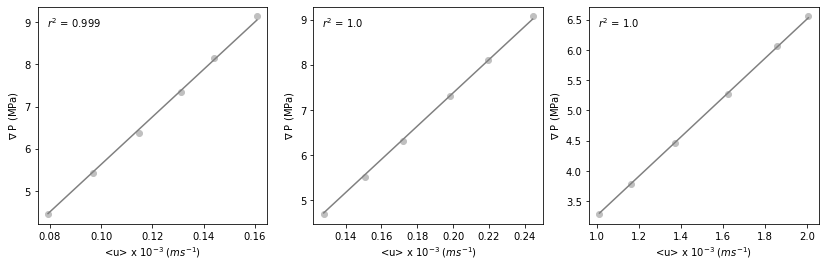

In [10]:
predictions = pd.DataFrame()
fit = pd.DataFrame(index = range(2))
a_values = np.zeros(3)

fig, axs = plt.subplots(1,3,figsize=[14,4]) # Creates subplots for each sample
for i,name in enumerate(names): # Runs through each sample in a loop
    # Plots <u> against nabla_P for each sample
    axs[i].scatter(name['u']*1000,name['nabla_P']/(10**6), color='silver')
    axs[i].set(xlabel='<u> x $10^{-3}$ ($ms^{-1}$)', ylabel=''r'$\nabla$ P (MPa)') # Adds axis labels
    
    x = name['u'].to_numpy() # Changes DataFrame columns to numpy arrays 
    y = name['nabla_P'].to_numpy()
    
    X = x[:,np.newaxis] # Changes the orientation of the x array
    a, _, _, _ = np.linalg.lstsq(X,y, rcond=-1) # Minimises to fit a line to the data with y-intercept of 0

    axs[i].plot(x*1000, (x*a)/(10**6), color='gray') # Plots the fitted line on the graph
    y_predict = a*x # Creates variable of the predicted y values
    
    # Places x and predicted y in dataframe
    #temp = pd.DataFrame({f'u{i}':name['u'],f'y{i}':y}).reset_index(drop=True)
    #predictions=pd.concat([predictions,temp],axis=1).reset_index(drop=True) # Adds to the dataframe
    
    a_values[i] = a
    
    # Finds the r value of the fit
    corr_matrix = np.corrcoef(name['nabla_P'],a*x)
    corr = corr_matrix[0,1]
    R_sq = corr**2 # Square to find the r^2 value
    
    # Adds the value of R_sq as text on each subplot
    axs[i].text(0.04,0.96,f'$r^2$ = {round(R_sq,3)}', ha='left', va='top', transform=axs[i].transAxes)
    print(f' a = {a}, r^2 = {round(R_sq,3)}')

The permeability of the sample can be found from the gradient of the fitted line, a, using Darcy's law.

In [11]:
k = np.zeros(3) # Creates new empty array to hold the permeability values

for i in range(len(k)):
    k[i] = mu_N/a_values[i] # Calculates the permeability of each sample.
k # Array holding the permeability of each sample

array([3.12601252e-16, 4.77170994e-16, 5.39996932e-15])

Now the permeability has been calculated from the raw measured data, each the data for each sample can be checked to see if a Forchheimer or Klinkenberg correction are required. See Appendix A5 for details on each correction.

# Forchheimer correction

To check if the Forchheimer correction is required, the permeability (k_meas) first needs to be calculated from each data point for a sample, using Eq. 5.2.

In [12]:
for i in range(3):
    name = names[i] # Takes each of the samples in turn
    # Calculates the Darcian permeability of each sample (Eq. 5.2)
    name['k_meas'] = (name['Q_(m^3/s)']* mu_N)/(characteristics.iloc[i,6]*name['nabla_P'])

The need for the Forchheimer correction is checked by seeing if the fit between 1/k_meas and Q is linear. The y-intercept of a equation fitted to the linear portion of this curve is equal to the inverse of the Forchheimer corrected permeability (1/k_forch)

 a = 1.7105151573702452e+21, b = 3127520187282468.5, r^2 = 0.422
 a = 8.634595549555313e+20, b = 2041251323600802.8, r^2 = 0.837
 a = 4.4389758876701184e+18, b = 182870799652751.12, r^2 = 0.935


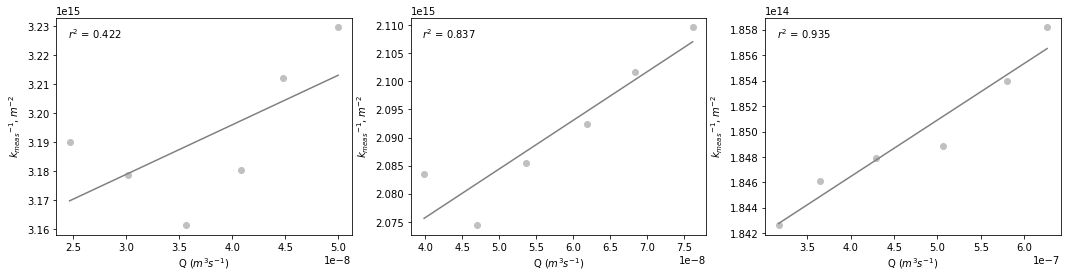

In [19]:
# Creates empty array to hold the values of b found, needed to find corrected permeability
b_values = np.zeros(3)

fig, axs = plt.subplots(1,3,figsize=[18,4]) # Creates subplots for each sample
for i,name in enumerate(names): # Runs through each sample in a loop
    # Plots Q against 1/k_meas for each sample
    axs[i].scatter(name['Q_(m^3/s)'],1/(name['k_meas']), color='silver')
    axs[i].set(xlabel='Q ($m^3s^{-1}$)', ylabel='${k_{meas}}^{-1}, m^{-2}$') # Adds axis labels
    
    a, b = np.polyfit(name['Q_(m^3/s)'],1/(name['k_meas']), 1) # Fits a straight line to the data
    axs[i].plot(name['Q_(m^3/s)'], name['Q_(m^3/s)']*a+b, color='gray') # Plots the fitted line on the graph
    
    b_values[i] = b # Places b_value for each sample into the array
    
    # Finds the r value of the fit
    corr_matrix = np.corrcoef(1/(name['k_meas']),a*name['Q_(m^3/s)']+b)
    corr = corr_matrix[0,1]
    R_sq = corr**2 # Square to find the r^2 value
    
    # Adds the value of R_sq as text on each subplot
    axs[i].text(0.04,0.96,f'$r^2$ = {round(R_sq,3)}', ha='left', va='top', transform=axs[i].transAxes)
    print(f' a = {a}, b = {b}, r^2 = {round(R_sq,3)}')

Here the first sample shows a low r^2 value, indicating that this does not require a Forchheimer correction. The other two samples show a stronger correlation and their Forchheimer corrected permeabilities can be found from the fit above.

The permeability of the first sample that does not need correcting can be taken from above.

In [23]:
print(f' The permeability of TF1_1 is {k[0]} m^2')

 The permeability of TF1_1 is 3.1260125179985756e-16 m^2


In [27]:
k_forch = 1/b_values
k_forch

print(f'The Forchheimer corrected permeability of the second two samples is {k_forch[1]} m^2 for TF1_2 and {k_forch[2]} m^2 for TF2_1.')

The Forchheimer corrected permeability of the second two samples is 4.898955794605353e-16 m^2 for TF1_2 and 5.468341593621702e-15 m^2 for TF2_1.


# Klinkenberg correction

The data can also be checked to see if the Klinkenberg correction needs to be applied. To do this, the inverse of the mean pressure of each measurement needs to be calculated.

In [28]:
for name in names:
    name['P_m'] = (name['P_up'] + P_atm)/2
    name['P_m_inv'] = 1/name['P_m']

 a = 3.179797437684518e-12, b = 2.953279377312609e-16, r^2 = 0.348
 a = 6.222515697405162e-12, b = 4.4312534753800817e-16, r^2 = 0.786
 a = 3.455868675281651e-11, b = 5.192332387762109e-15, r^2 = 0.911


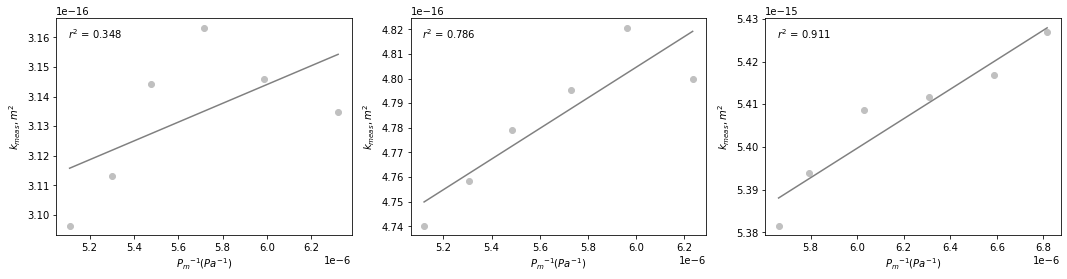

In [35]:
b_values_klink = np.zeros(3)

fig, axs = plt.subplots(1,3,figsize=[18,4]) # Creates subplots for each sample
for i,name in enumerate(names): # Runs through each sample in a loop
    # Plots 1/P_m against k_meas for each sample
    axs[i].scatter(name['P_m_inv'],name['k_meas'], color='silver')
    axs[i].set(xlabel='${P_m}^{-1} (Pa^{-1}$)', ylabel='$k_{meas}, m^2$') # Adds axis labels
    
    a, b = np.polyfit(name['P_m_inv'],name['k_meas'], 1) # Fits a straight line to the data
    axs[i].plot(name['P_m_inv'], name['P_m_inv']*a+b, color='gray') # Plots the fitted line on the graph
    
    b_values_klink[i] = b # Places b_value for each sample into the array
    
    # Finds the r value of the fit
    corr_matrix = np.corrcoef(name['k_meas'],a*name['P_m_inv']+b)
    corr = corr_matrix[0,1]
    R_sq = corr**2 # Square to find the r^2 value
    
    # Adds the value of R_sq as text on each subplot
    axs[i].text(0.04,0.96,f'$r^2$ = {round(R_sq,3)}', ha='left', va='top', transform=axs[i].transAxes)
    print(f' a = {a}, b = {b}, r^2 = {round(R_sq,3)}')

In the above data the first two samples do not show a strong correlation, suggesting that a Klinkenberg correction is only required for the third sample. The corrected permeability, k_klink, is given by the y-intercept of the best fit line above.

In [36]:
print(f'The corrected permeability of the third sample would be {b_values_klink[2]} m^2')

The corrected permeability of the third sample is 5.192332387762109e-15 m^2
